In [ ]:
import h5py
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import snntorch as snn
from snntorch import spikeplot as splt
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from snntorch import surrogate
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F

In [1]:
SEED = 134
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

print("PyTorch Version: ", torch.__version__)
print(f"Using {'GPU' if str(device) == 'cuda' else 'CPU'}.")

# Check for MPS (Apple Silicon GPU) availability
#if torch.backends.mps.is_available():
#    device = torch.device("mps")
#    print("Using MPS (Apple Silicon GPU)")
#else:
#    device = torch.device("cpu")
#    print("MPS not available, using CPU")
    
class SHDDataset(Dataset):
    def __init__(self, file_path, nb_steps=100):
        self.nb_steps = nb_steps
        self.nb_units = 700
        self.max_time = 1.4  # seconds
        
        # Load data from h5 file
        with h5py.File(file_path, 'r') as h5file:
            self.spike_times = h5file['spikes']['times'][()]
            self.spike_units = h5file['spikes']['units'][()]
            self.labels = h5file['labels'][()]
        
        # Create time bins
        self.time_bins = np.linspace(0, self.max_time, num=self.nb_steps)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        times = self.spike_times[index]
        units = self.spike_units[index]
        
        # Discretize spike times
        time_indices = np.digitize(times, self.time_bins) - 1
        
        # Create sparse tensor
        indices = torch.LongTensor(np.array([time_indices, units]))
        values = torch.FloatTensor(np.ones_like(times))
        spike_tensor = torch.sparse_coo_tensor(indices, values, size=(self.nb_steps, self.nb_units))
        
        return spike_tensor.to_dense(), self.labels[index]

def collate_fn(batch):
    # Pad sequences to the same length
    spikes, labels = zip(*batch)
    padded_spikes = torch.nn.utils.rnn.pad_sequence(spikes, batch_first=True)
    lengths = torch.LongTensor([spike.shape[0] for spike in spikes])
    labels = torch.LongTensor(labels)
    return padded_spikes, lengths, labels

def load_shd_data(train_path, test_path, batch_size=32, val_ratio=0.2):
    # Load datasets
    train_dataset = SHDDataset(train_path)
    full_test_dataset = SHDDataset(test_path)
    
    # Split test set into validation and test
    val_size = int(len(full_test_dataset) * val_ratio)
    test_size = len(full_test_dataset) - val_size
    val_dataset, test_dataset = random_split(full_test_dataset, [val_size, test_size], 
                                             generator=torch.Generator().manual_seed(42))

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    
    return train_loader, val_loader, test_loader

PyTorch Version:  2.3.0+cu121
Using GPU.


In [2]:


def visualize_sample(dataset, index=0):
    # Get a single sample
    spike_tensor, label = dataset[index]
    
    # Convert to numpy array if it's not already
    if isinstance(spike_tensor, torch.Tensor):
        spike_array = spike_tensor.numpy()
    else:
        spike_array = spike_tensor
    
    # Create a figure
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Use snntorch.spikeplot to visualize the sample
    splt.raster(torch.tensor(spike_array).float(), ax, s=0.5, c='black')
    
    ax.set_title(f"Spike Raster Plot for Sample {index} (Label: {label})")
    ax.set_xlabel("Time Steps")
    ax.set_ylabel("Neuron Index")
    
    plt.tight_layout()
    plt.show()

# Load your dataset
train_path = "/Users/solaimane/Downloads/shd_train.h5"
train_dataset = SHDDataset(train_path)

# Visualize a sample
visualize_sample(train_dataset, index=1)

In [4]:
class RLIF(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, beta=0.98, threshold=1.0, 
                 spike_grad=surrogate.fast_sigmoid(), dropout_rate=0.5):
        super(RLIF, self).__init__()
        
        # Parameters
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.beta = beta
        self.threshold = threshold
        
        # Layers
        self.fc_in = nn.Linear(input_size, hidden_size)
        self.recurrent = nn.Linear(hidden_size, hidden_size)
        self.fc_out = nn.Linear(hidden_size, output_size)
        
        # Dropout layers
        self.dropout_in = nn.Dropout(dropout_rate)
        self.dropout_rec = nn.Dropout(dropout_rate)
        
        # LIF neuron
        self.lif = snn.Leaky(beta=beta, threshold=threshold, spike_grad=spike_grad)
        
    def forward(self, x):
        # Initialize hidden states and outputs
        batch_size = x.size(0)
        time_steps = x.size(1)
        hidden = self.lif.init_leaky()
        spk_rec = []
        mem_rec = []
        
        for step in range(time_steps):
            # Get current input
            cur_input = x[:, step, :]
            
            # Hidden layer with dropout
            z = self.dropout_in(self.fc_in(cur_input))
            
            # Add recurrent input if there was a previous spike
            if len(spk_rec) > 0:
                z += self.dropout_rec(self.recurrent(spk_rec[-1]))
            
            # LIF neuron operation
            spk, mem = self.lif(z, hidden)
            hidden = mem
            
            spk_rec.append(spk)
            mem_rec.append(mem)
        
        # Stack recorded spikes and membrane potentials
        spk_rec = torch.stack(spk_rec, dim=1)
        mem_rec = torch.stack(mem_rec, dim=1)
        
        # Read out the final layer
        outputs = self.fc_out(spk_rec)
        
        return outputs, spk_rec, mem_rec

In [5]:
# Hyperparameters
input_size = 700
hidden_size = 873
output_size = 20
batch_size = 32
learning_rate = 0.001
num_epochs = 25
dropout_rate = 0.5

# Load data
train_path = '/user/HS402/ya00617/Downloads/shd_train.h5'
test_path = '/user/HS402/ya00617/Downloads/shd_test.h5'
train_loader, val_loader, test_loader = load_shd_data(train_path, test_path, batch_size=batch_size)

# Initialize model, loss function, and optimizer
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RLIF(input_size, hidden_size, output_size, dropout_rate=dropout_rate).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.7, patience=3, verbose=True)
print(model)

RLIF(
  (fc_in): Linear(in_features=700, out_features=873, bias=True)
  (recurrent): Linear(in_features=873, out_features=873, bias=True)
  (fc_out): Linear(in_features=873, out_features=20, bias=True)
  (dropout_in): Dropout(p=0.5, inplace=False)
  (dropout_rec): Dropout(p=0.5, inplace=False)
  (lif): Leaky()
)


/user/HS402/ya00617/.local/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/user/HS402/ya00617/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [6]:
# Training function
def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for spikes, lengths, labels in tqdm(loader, desc="Training"):
        spikes, labels = spikes.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs, _, _ = model(spikes)
        loss = criterion(outputs.mean(dim=1), labels)  # Average over time steps
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = outputs.mean(dim=1).max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    return total_loss / len(loader), correct / total

# Evaluation function
def evaluate(model, loader, criterion, device, return_predictions=False):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for spikes, lengths, labels in tqdm(loader, desc="Evaluating"):
            spikes, labels = spikes.to(device), labels.to(device)
            
            outputs, _, _ = model(spikes)
            loss = criterion(outputs.mean(dim=1), labels)
            
            total_loss += loss.item()
            _, predicted = outputs.mean(dim=1).max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            if return_predictions:
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
    
    if return_predictions:
        return total_loss / len(loader), correct / total, all_preds, all_labels
    else:
        return total_loss / len(loader), correct / total


In [7]:
# Lists to store losses, accuracies, and learning rates
train_losses = []
train_accs = []
val_losses = []
val_accs = []
learning_rates = []

# Training loop
best_val_acc = 0
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    
    # Record losses, accuracies, and current learning rate
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    learning_rates.append(optimizer.param_groups[0]['lr'])
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Step the scheduler
    scheduler.step(val_acc)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print("Saved best model")
    
    print()

Evaluating: 100%|███████████████████████████████| 15/15 [00:00<00:00, 63.49it/s]


Epoch 1/25
Train Loss: 2.2131, Train Acc: 0.2569
Val Loss: 1.7325, Val Acc: 0.3827
Learning Rate: 0.001000
Saved best model



Evaluating: 100%|███████████████████████████████| 15/15 [00:00<00:00, 64.94it/s]


Epoch 2/25
Train Loss: 1.5412, Train Acc: 0.4616
Val Loss: 1.3501, Val Acc: 0.5044
Learning Rate: 0.001000
Saved best model



Evaluating: 100%|███████████████████████████████| 15/15 [00:00<00:00, 63.96it/s]


Epoch 3/25
Train Loss: 1.3178, Train Acc: 0.5397
Val Loss: 1.2007, Val Acc: 0.5642
Learning Rate: 0.001000
Saved best model



Evaluating: 100%|███████████████████████████████| 15/15 [00:00<00:00, 63.15it/s]


Epoch 4/25
Train Loss: 1.2380, Train Acc: 0.5658
Val Loss: 1.0911, Val Acc: 0.5951
Learning Rate: 0.001000
Saved best model



Evaluating: 100%|███████████████████████████████| 15/15 [00:00<00:00, 64.51it/s]


Epoch 5/25
Train Loss: 1.1489, Train Acc: 0.6002
Val Loss: 0.9983, Val Acc: 0.6018
Learning Rate: 0.001000
Saved best model



Evaluating: 100%|███████████████████████████████| 15/15 [00:00<00:00, 63.61it/s]


Epoch 6/25
Train Loss: 1.1296, Train Acc: 0.5982
Val Loss: 0.9195, Val Acc: 0.7058
Learning Rate: 0.001000
Saved best model



Evaluating: 100%|███████████████████████████████| 15/15 [00:00<00:00, 64.01it/s]


Epoch 7/25
Train Loss: 1.0665, Train Acc: 0.6319
Val Loss: 1.0002, Val Acc: 0.6726
Learning Rate: 0.001000



Evaluating: 100%|███████████████████████████████| 15/15 [00:00<00:00, 63.78it/s]


Epoch 8/25
Train Loss: 1.0635, Train Acc: 0.6290
Val Loss: 1.0509, Val Acc: 0.6504
Learning Rate: 0.001000



Evaluating: 100%|███████████████████████████████| 15/15 [00:00<00:00, 64.30it/s]


Epoch 9/25
Train Loss: 1.0342, Train Acc: 0.6392
Val Loss: 0.9922, Val Acc: 0.6438
Learning Rate: 0.001000



Evaluating: 100%|███████████████████████████████| 15/15 [00:00<00:00, 63.95it/s]


Epoch 10/25
Train Loss: 1.0071, Train Acc: 0.6540
Val Loss: 0.9653, Val Acc: 0.7035
Learning Rate: 0.001000



Evaluating: 100%|███████████████████████████████| 15/15 [00:00<00:00, 63.71it/s]


Epoch 11/25
Train Loss: 0.9247, Train Acc: 0.6759
Val Loss: 0.8385, Val Acc: 0.7124
Learning Rate: 0.000700
Saved best model



Evaluating: 100%|███████████████████████████████| 15/15 [00:00<00:00, 64.25it/s]


Epoch 12/25
Train Loss: 0.8807, Train Acc: 0.6957
Val Loss: 0.8137, Val Acc: 0.7345
Learning Rate: 0.000700
Saved best model



Evaluating: 100%|███████████████████████████████| 15/15 [00:00<00:00, 64.13it/s]


Epoch 13/25
Train Loss: 0.8357, Train Acc: 0.7114
Val Loss: 0.8952, Val Acc: 0.7212
Learning Rate: 0.000700



Evaluating: 100%|███████████████████████████████| 15/15 [00:00<00:00, 63.57it/s]


Epoch 14/25
Train Loss: 0.8060, Train Acc: 0.7195
Val Loss: 0.8374, Val Acc: 0.7367
Learning Rate: 0.000700
Saved best model



Evaluating: 100%|███████████████████████████████| 15/15 [00:00<00:00, 64.07it/s]


Epoch 15/25
Train Loss: 0.7971, Train Acc: 0.7260
Val Loss: 0.9854, Val Acc: 0.6836
Learning Rate: 0.000700



Evaluating: 100%|███████████████████████████████| 15/15 [00:00<00:00, 63.90it/s]


Epoch 16/25
Train Loss: 0.8073, Train Acc: 0.7223
Val Loss: 0.8283, Val Acc: 0.7389
Learning Rate: 0.000700
Saved best model



Evaluating: 100%|███████████████████████████████| 15/15 [00:00<00:00, 64.02it/s]


Epoch 17/25
Train Loss: 0.7782, Train Acc: 0.7348
Val Loss: 0.8979, Val Acc: 0.7212
Learning Rate: 0.000700



Evaluating: 100%|███████████████████████████████| 15/15 [00:00<00:00, 64.36it/s]


Epoch 18/25
Train Loss: 0.7649, Train Acc: 0.7379
Val Loss: 0.8680, Val Acc: 0.7168
Learning Rate: 0.000700



Evaluating: 100%|███████████████████████████████| 15/15 [00:00<00:00, 63.39it/s]


Epoch 19/25
Train Loss: 0.7647, Train Acc: 0.7355
Val Loss: 0.8805, Val Acc: 0.6969
Learning Rate: 0.000700



Evaluating: 100%|███████████████████████████████| 15/15 [00:00<00:00, 62.91it/s]


Epoch 20/25
Train Loss: 0.7666, Train Acc: 0.7392
Val Loss: 0.8624, Val Acc: 0.7124
Learning Rate: 0.000700



Evaluating: 100%|███████████████████████████████| 15/15 [00:00<00:00, 62.85it/s]


Epoch 21/25
Train Loss: 0.6914, Train Acc: 0.7690
Val Loss: 0.8530, Val Acc: 0.7212
Learning Rate: 0.000490



Evaluating: 100%|███████████████████████████████| 15/15 [00:00<00:00, 65.08it/s]


Epoch 22/25
Train Loss: 0.6491, Train Acc: 0.7836
Val Loss: 0.7740, Val Acc: 0.7412
Learning Rate: 0.000490
Saved best model



Evaluating: 100%|███████████████████████████████| 15/15 [00:00<00:00, 64.27it/s]


Epoch 23/25
Train Loss: 0.6483, Train Acc: 0.7794
Val Loss: 0.7518, Val Acc: 0.7566
Learning Rate: 0.000490
Saved best model



Evaluating: 100%|███████████████████████████████| 15/15 [00:00<00:00, 63.65it/s]


Epoch 24/25
Train Loss: 0.6327, Train Acc: 0.7831
Val Loss: 0.7104, Val Acc: 0.7765
Learning Rate: 0.000490
Saved best model



Evaluating: 100%|███████████████████████████████| 15/15 [00:00<00:00, 63.42it/s]

Epoch 25/25
Train Loss: 0.6289, Train Acc: 0.7838
Val Loss: 0.8217, Val Acc: 0.7389
Learning Rate: 0.000490



Evaluating: 100%|███████████████████████████████| 57/57 [00:00<00:00, 63.62it/s]


Test Loss: 0.7591, Test Acc: 0.7566

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.31      0.42        89
           1       0.61      0.45      0.52        89
           2       0.93      0.50      0.65        86
           3       0.77      0.53      0.63        89
           4       0.94      1.00      0.97        87
           5       0.91      0.77      0.83        90
           6       0.93      0.97      0.95        90
           7       0.65      0.62      0.63        86
           8       0.92      0.99      0.95        93
           9       0.72      0.88      0.79        83
          10       0.66      0.85      0.74        96
          11       0.95      0.98      0.97       102
          12       0.91      0.72      0.80        94
          13       0.53      0.88      0.66        89
          14       0.62      0.51      0.56        88
          15       0.53      0.99      0.69        85
          16       0.

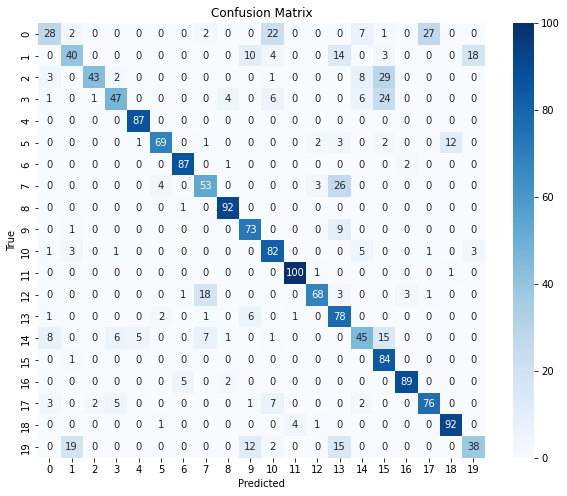

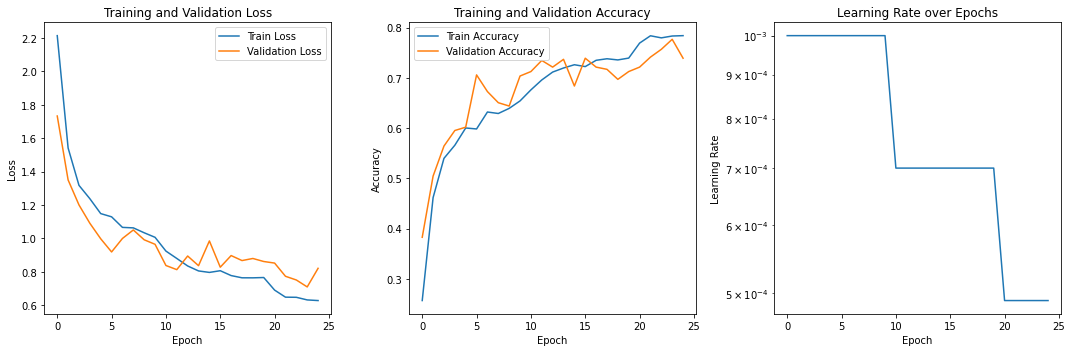


Best validation accuracy: 0.7765 at epoch 24


In [8]:
# Evaluate on test set and get predictions
model.load_state_dict(torch.load('best_model.pth'))
test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, criterion, device, return_predictions=True)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(test_labels, test_preds))

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot training and validation curves
plt.figure(figsize=(15, 5))

# Plot losses
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot accuracies
plt.subplot(1, 3, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot learning rate
plt.subplot(1, 3, 3)
plt.plot(learning_rates)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate over Epochs')
plt.yscale('log')

plt.tight_layout()
plt.show()

# Print best validation accuracy and corresponding epoch
best_epoch = val_accs.index(max(val_accs)) + 1
print(f"\nBest validation accuracy: {max(val_accs):.4f} at epoch {best_epoch}")